In [2]:
# https://www.tensorflow.org/install/source#gpu
! nvcc  --version

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

import math
import copy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from src.utils import apply_circular_mask, cartesian_to_polar_grid, polar_transform, polar_transform_inv
from src.model import toeplitz_extractor

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


/var/tmp/ipykernel_46077/720885125.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-13 09:37:10.633854: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 09:37:10.633955: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 09:37:10.633979: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] 

Num GPUs Available:  1


2024-02-13 09:37:16.541788: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1014 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:03:00.0, compute capability: 8.6


In [11]:
dataset_name = 'mnist' # fashion_mnist
image_size = 28
batch_size = 1024
n_epochs = 10
n_classes = 10
latent_dim = 4

# see polar_transform
radius = (np.array([image_size, image_size])**2).sum()**0.5/2
len_beam = int(round(radius))
n_beams = int(round(radius*2*np.pi))
print(len_beam, n_beams)

plt.rcParams["image.cmap"] = "gray"

train_dataset = tfds.load(dataset_name, split='train', shuffle_files=False)
test_dataset = tfds.load(dataset_name, split='test', shuffle_files=False)

def preprocess(example):
    image = tf.cast(example['image'], tf.float32) / 255.
    return {
        'image': image,
        'label': example['label'],
        'polar': polar_transform(image)
    }

train_dataset = train_dataset.map(preprocess).shuffle(buffer_size=10000).batch(batch_size)
test_dataset = test_dataset.map(preprocess).batch(batch_size)

20 124


tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


2024-02-13 09:48:01.236559: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


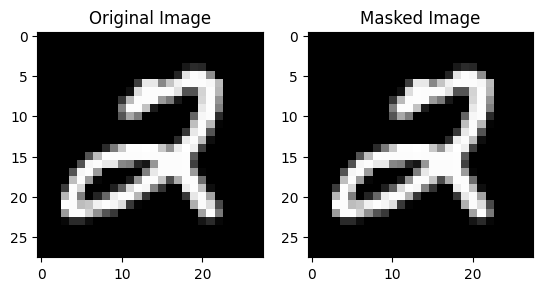

In [13]:
data = next(iter(test_dataset))
image = data['image'][0]
image = (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image))
masked_image = apply_circular_mask(image)

print(tf.reduce_min(image), tf.reduce_max(image))

plt.subplot(1, 2, 1)
plt.imshow(image.numpy())
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(masked_image.numpy())
plt.title("Masked Image")

plt.show()

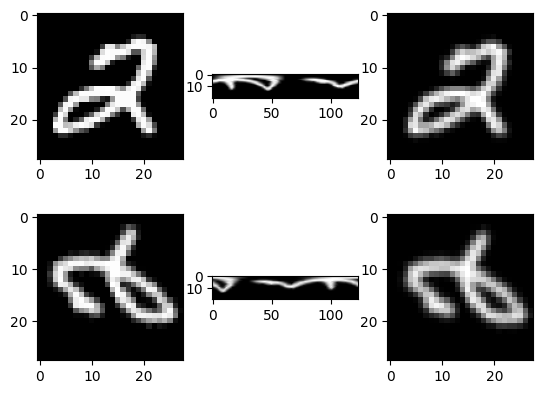

In [14]:
fig, axs = plt.subplots(2,3)

rot_image = tfa.image.rotate(masked_image, 90., interpolation='bilinear')
rot_image = tf.cast(rot_image, tf.float32)

axs[0, 0].imshow(masked_image)
axs[1, 0].imshow(rot_image)

polar = data['polar'][0]#polar_transform(masked_image)
rot_polar = polar_transform(rot_image)

axs[0, 1].imshow(polar)
axs[1, 1].imshow(rot_polar)

polar_inv = polar_transform_inv(polar.numpy(), output=(image_size, image_size))
rot_polar_inv = polar_transform_inv(rot_polar.numpy(), output=(image_size, image_size))

axs[0, 2].imshow(polar_inv)
axs[1, 2].imshow(rot_polar_inv)

plt.show()

(124, 124)


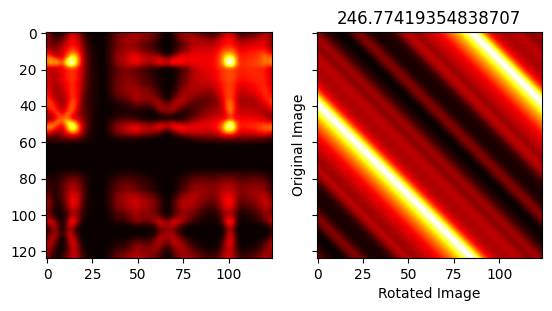

In [5]:
# dot product over W
# [C x H x W] * [C x W x H] = [C x H x H]
dot = tf.transpose(polar[..., 0], (1, 0)) @ tf.transpose(rot_polar[..., 0], (0, 1))
# average over [C] -> [H x H]
# dot = tf.reduce_mean(dot, axis=0)
print(dot.shape)

fig, axs = plt.subplots(1,2,sharex=True, sharey=True)
axs[0].imshow(dot, cmap='hot', interpolation='bilinear')

toeplitz_matrices = toeplitz_extractor(n_beams)
diag_score = tf.reduce_sum(toeplitz_matrices * dot[None], axis=(-1, -2), keepdims=True)
toeplitz_matrices *= diag_score
toeplitz = tf.reduce_sum(toeplitz_matrices, axis=0)
axs[1].imshow(toeplitz, cmap='hot', interpolation='bilinear')

n = n_beams - tf.math.argmax(diag_score).numpy()[0, 0]
plt.title((n/n_beams) * 360)
plt.xlabel('Rotated Image')
plt.ylabel('Original Image')
plt.show()

(20, 124, 1) (20, 124, 1)


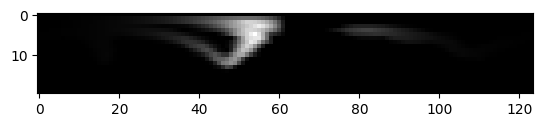

In [20]:
scale = 10.
loc = 0.

# Calculate the center of the kernel (assuming even array size)
center = int(n_beams / 2)

# Create an array of positions relative to the center
positions = tf.range(-center, center, dtype=tf.float32)

# Calculate the Gaussian values using the formula
# kernel = tf.exp(-tf.square(positions) / (2 * sigma**2))
# kernel = tf.exp(-2. * tf.abs(positions))
kernel = tf.exp(-tf.abs(positions-loc)/scale)/(2.*scale)

# Normalize the kernel to sum to 1
kernel = kernel / tf.reduce_sum(kernel)

# masking the input
mask = tf.tile(kernel[None, :, None], [len_beam, 1, 1])
print(polar.shape, mask.shape)
masked_polar = polar * mask

plt.imshow(masked_polar)
plt.show()